# Intro Task, Object Localization 

In [ ]:
# install libraries/packages/modules 
#MAKE SURE RUNTYPE IS SET TO GPU
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-g3i9hcmm
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-g3i9hcmm
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125709 sha256=964537d8b623c811900d334b456fd03c3e74445332a730550375dca713ed3389
  Stored in directory: /tmp/pip-ephem-wheel-cache-orhjcgtx/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
L

In [ ]:
# Download Dataset

!git clone https://github.com/Matt-Caruso/HoloLens2-Object-localization-

Cloning into 'HoloLens2-Object-localization-'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 205 (delta 13), reused 10 (delta 3), pack-reused 175
Receiving objects: 100% (205/205), 18.48 MiB | 39.10 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/HoloLens2-Object-localization-')

# Configurations

In [ ]:
CSV_FILE = '/content/HoloLens2-Object-localization-/train_file - Sheet1 (2).csv'
DATA_DIR = '/content/HoloLens2-Object-localization-'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODULE_NAME = 'efficientnet_b0'

NUM_COR = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/Diamond1.jpg,120,180,1100,1190,3024,4032,Diamond
1,train_images/Diamond10.jpg,200,220,700,760,3024,4032,Diamond
2,train_images/Diamond100.jpg,220,350,950,1000,3024,4032,Diamond
3,train_images/Diamond101.jpg,220,200,650,650,3024,4032,Diamond
4,train_images/Diamond102.jpg,450,450,950,1150,3024,4032,Diamond
...,...,...,...,...,...,...,...,...
132,train_images/Diamond95.jpg,190,260,500,500,3024,4032,Diamond
133,train_images/Diamond96.jpg,150,160,440,460,3024,4032,Diamond
134,train_images/Diamond97.jpg,260,300,650,650,3024,4032,Diamond
135,train_images/Diamond98.jpg,500,400,830,750,3024,4032,Diamond


# Understand the dataset

In [ ]:
df[df.columns[0]].count()

137

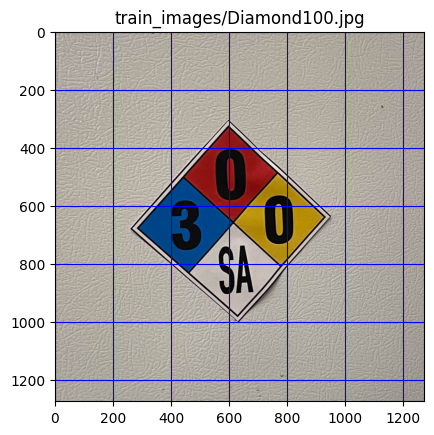

In [ ]:
row = df.iloc[2] #
img = cv2.imread(DATA_DIR + '/' + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.grid(color="blue")
plt.title(row.img_path)
plt.imshow(img)

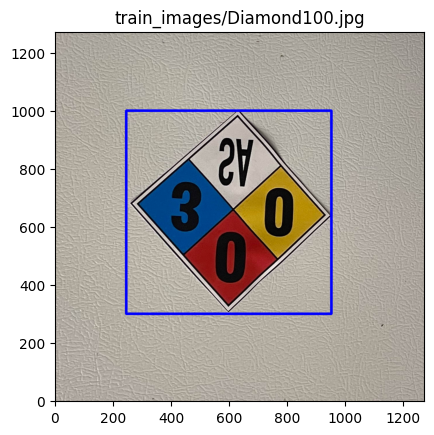

(<matplotlib.image.AxesImage at 0x7f45c56d5d50>,
 Text(0.5, 1.0, 'train_images/Diamond100.jpg'),
 None,
 None)

In [ ]:
row = df.iloc[2] #
img = cv2.imread(DATA_DIR + '/' + row.img_path)
pt1 = (row.xmin + 25, row.ymin - 50	)
pt2 = (row.xmax + 2, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 8)
plt.title(row.img_path)
#plt.imshow(bnd_box_img)
#plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
#plt.grid( color='blue')
plt.imshow(img[:,:,::-1]), plt.title(row.img_path), plt.gca().invert_yaxis(), plt.show()

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox = [[xmin, ymin, xmax, ymax]]

  
    img_path = ((DATA_DIR + '/' + row.img_path))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    bbox = torch.Tensor(bbox)

    return img, bbox
    


In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f"Total examples in trainset : {len(trainset)}")
print(f"Total examples in validset : {len(validset)}")

Total examples in trainset : 109
Total examples in validset : 28


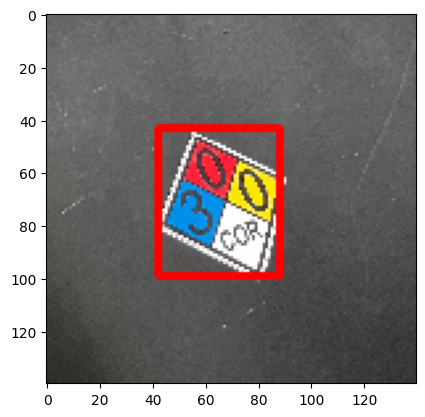

In [ ]:
img, bbox = validset[11]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 7
Total no. batches in validloader : 2


In [ ]:

for images, bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn 
import timm

In [ ]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODULE_NAME, pretrained = True, num_classes = 4)

  def forward(self,images, gt_bboxes = None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE)

RuntimeError: ignored

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [ ]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(dataloader):

      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

  return total_loss / len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("WEIGHTS_ARE_SAVED")
    best_valid_loss = valid_loss

  print(f"EPOCH : {i + 1 } train loss : {train_loss} valid loss : {valid_loss}")


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 1 train loss : 6043.974888392857 valid loss : 1281.63525390625


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 2 train loss : 2693.6037946428573 valid loss : 4300.01025390625


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 3 train loss : 1443.0183628627233 valid loss : 4137.404541015625


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 4 train loss : 1035.70161655971 valid loss : 435.3385314941406


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 5 train loss : 760.3109915597098 valid loss : 171.42172241210938


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 6 train loss : 582.8396257672991 valid loss : 82.59076690673828


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 7 train loss : 425.30275181361606 valid loss : 84.45758819580078


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 8 train loss : 347.4702388218471 valid loss : 69.9261360168457


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 9 train loss : 237.9199458530971 valid loss : 82.09056854248047


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 10 train loss : 197.735107421875 valid loss : 69.48421669006348


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 11 train loss : 189.37501525878906 valid loss : 93.52433395385742


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 12 train loss : 164.8293625967843 valid loss : 90.08611679077148


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 13 train loss : 137.73006657191686 valid loss : 67.2451000213623


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 14 train loss : 96.65056392124721 valid loss : 61.34451866149902


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 15 train loss : 121.21578870500836 valid loss : 84.97217559814453


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 16 train loss : 100.6273923601423 valid loss : 45.84361457824707


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 17 train loss : 87.715578351702 valid loss : 64.6506118774414


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 18 train loss : 99.77847181047711 valid loss : 50.699432373046875


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 19 train loss : 86.36105128696987 valid loss : 45.97825622558594


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 20 train loss : 65.67506953648159 valid loss : 57.321510314941406


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 21 train loss : 90.38783318655831 valid loss : 127.67688369750977


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 22 train loss : 82.00658362252372 valid loss : 91.99195098876953


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 23 train loss : 93.45836475917271 valid loss : 88.71134185791016


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 24 train loss : 68.7923093523298 valid loss : 68.0914478302002


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 25 train loss : 62.27927453177316 valid loss : 66.62571716308594


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 26 train loss : 61.99685559953962 valid loss : 43.52947235107422


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 27 train loss : 58.459824970790315 valid loss : 37.74509620666504


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 28 train loss : 62.863471439906526 valid loss : 48.158935546875


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 29 train loss : 59.32714108058384 valid loss : 32.726789474487305


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 30 train loss : 46.70837729317801 valid loss : 41.36753463745117


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 31 train loss : 43.29501724243164 valid loss : 49.0947208404541


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 32 train loss : 51.11210468837193 valid loss : 48.02943420410156


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 33 train loss : 45.628924233572825 valid loss : 37.44017791748047


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WEIGHTS_ARE_SAVED
EPOCH : 34 train loss : 83.71163558959961 valid loss : 27.55823802947998


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 35 train loss : 57.24106706891741 valid loss : 32.175262451171875


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 36 train loss : 56.458086013793945 valid loss : 35.98431587219238


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 37 train loss : 45.19284929547991 valid loss : 49.83460235595703


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 38 train loss : 42.11032458714077 valid loss : 36.08158302307129


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 39 train loss : 54.04389926365444 valid loss : 37.75061225891113


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH : 40 train loss : 37.29916885920933 valid loss : 42.26986312866211


#Inference

In [ ]:
import utils

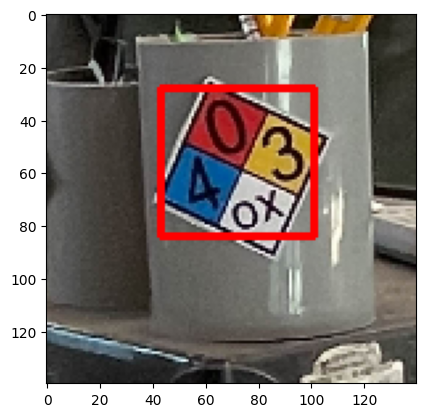

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
    
with torch.no_grad():

  image, gt_bbox = validset[23]
  image = image.unsqueeze(0).to(DEVICE)
  out_bbox = model(image)

  utils.plot(image, out_bbox)


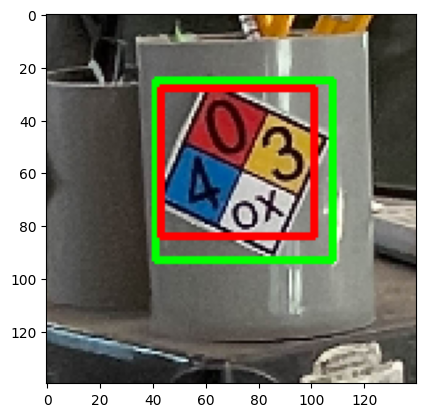

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
    
with torch.no_grad():

  image, gt_bbox = validset[23]
  image = image.unsqueeze(0).to(DEVICE)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)